# CNN Cancer Detection Kaggle Mini Project

The goal of this Kaggle competition, is to create an algorithm to identify metastatic cancer 
in small image patches taken from larger digital pathology scans. 
The data for this competition are 96x96 pixel images separated in both training and test sets.

## Introduction: Step 1
    
We will see how many training and test samples we have as well as verify the shapes of the samples are
96x96x3 (96x96 pixels, 3 colors for RGB).  Also, as this is a binary classification problem, I will
want to make sure the classes are balanced so as not to introduce any bias into the predictions

In [22]:
#import necessary packages and training labels
import numpy as np
import pandas as pd
import os

train_labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv', dtype=str)
print(train_labels.shape)

(220025, 2)


In [26]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [27]:
train_labels.dtypes

id       object
label    object
dtype: object

In [28]:
import os
print(len(os.listdir('../input/histopathologic-cancer-detection/train/')))
print(len(os.listdir('../input/histopathologic-cancer-detection/test/')))

220025
57458


So, we see we have 220,025 training samples and 57,458 test samples.

In [29]:
len(train_labels)

220025

## Step 2: Exploratory Data Analysis

I will now look to do any data cleaning and figure out my plan of how to approach this task.  Initially I will want to determine if the classes in the training set are unbalanced.

In [30]:
train_labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

<AxesSubplot:>

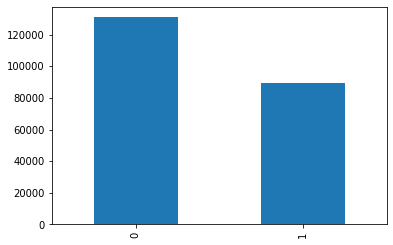

In [31]:
train_labels['label'].value_counts().plot(kind='bar')

There is a class imbalance in the training data with significantly more non-cancerous images (label '0') versus cancerous (label '1').  I will reduce the size of label 0 by random undersampling of that set in order to match the same size as the set of images with label 1.

In [3]:
train_labels.id = train_labels.id + '.tif'
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [33]:
#confirm final set has the expected amount and shape
train_labels.shape

(220025, 2)

In [34]:
#confirm final set has the expected value counts
train_labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

<AxesSubplot:>

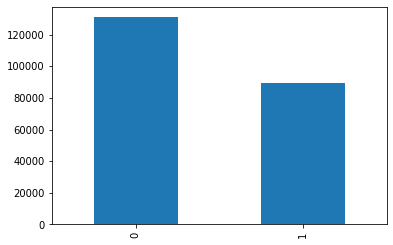

In [35]:
train_labels['label'].value_counts().plot(kind='bar')

Now I will look at a several images to see what we are actually trying to classif and confirm they are of the expected size

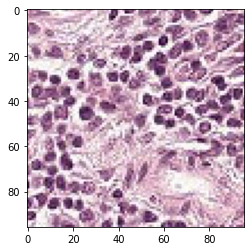

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(f'../input/histopathologic-cancer-detection/train/{train_labels.iloc[47,0]}')
imgplot = plt.imshow(img)

In [37]:
print(img.shape)

(96, 96, 3)


In [5]:
sample_imgs = np.random.choice(train_labels.index,15)

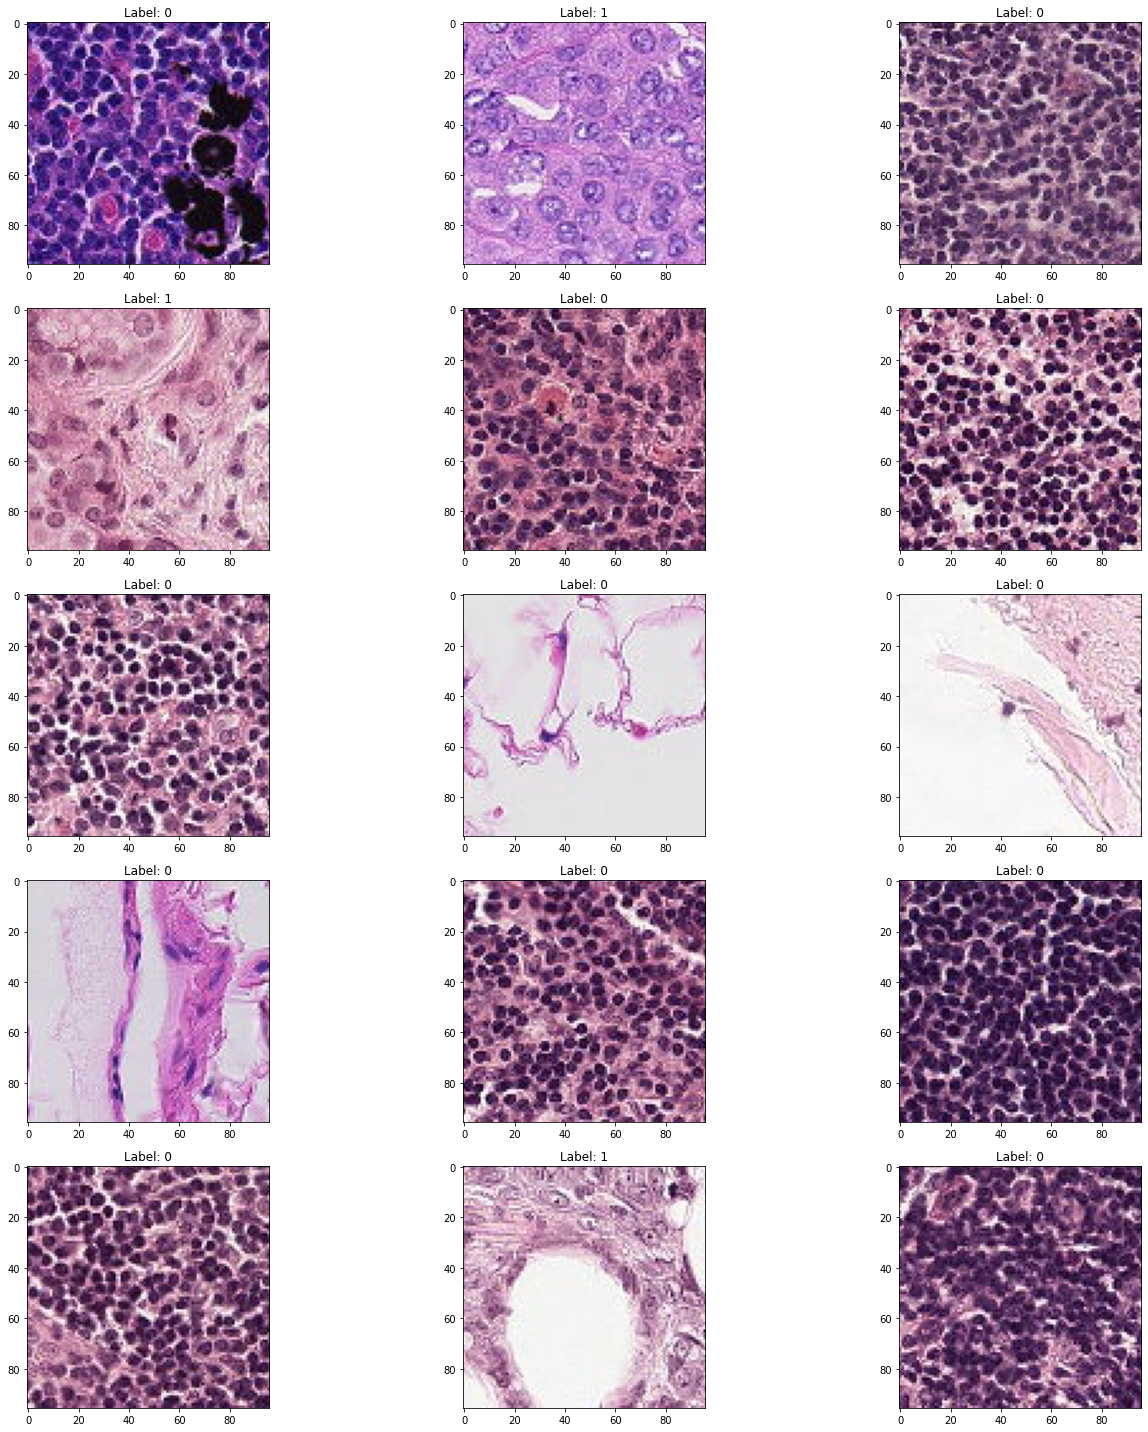

In [6]:
fig, ax = plt.subplots(5, 3,figsize=(20,20))

for i in range(0, sample_imgs.shape[0]):
    ax = plt.subplot(5, 3, i+1)
    img = mpimg.imread(f'../input/histopathologic-cancer-detection/train/{train_labels.iloc[sample_imgs[i],0]}')
    ax.imshow(img)
    lab = train_labels.iloc[sample_imgs[i],1]
    ax.set_title('Label: %s'%lab)
    
plt.tight_layout()

So, we can see some images are vastly different from others, and with no medical training I cant possibly tell which images are indicative of cancer and which arent.  Hopefully, with deep learning, the model will be able to!

## Step 3: Model Architecture
My goal is to create a base model which has 96x96 images. Then, I will use EfficientNet, ResNet, and EfficientNet prebuilt Keras applications for 20 epochs with a learning rate of 0.001. For the first step, I will split the training set into a training subset and a validation subset. I will use these same subsets throughout this process in order to remain consistent.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_df, valid_df = train_test_split(train_labels, test_size=0.2, random_state=1234, stratify=train_labels.label)

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import * 
import tensorflow.keras.applications.efficientnet as efn
import tensorflow.keras.applications.resnet_v2 as res
import tensorflow.keras.applications.inception_v3 as inc
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
# Helper Functions
def merge_history(hlist):
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

def vis_training(h, start=1):
    epoch_range = range(start, len(h['loss'])+1)
    s = slice(start-1, None)

    plt.figure(figsize=[14,4])

    n = int(len(h.keys()) / 2)

    for i in range(n):
        k = list(h.keys())[i]
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, h[k][s], label='Training')
        plt.plot(epoch_range, h['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

## Data Generators

In [12]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)
BATCH_SIZE = 64
train_path = "../input/histopathologic-cancer-detection/train"

In [13]:
train_loader = train_datagen.flow_from_dataframe(
    dataframe = valid_df,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96,96)
)

valid_loader = train_datagen.flow_from_dataframe(
    dataframe = valid_df,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96,96)
)

Found 44005 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [14]:
TR_STEPS = len(train_loader)
VA_STEPS = len(valid_loader)

print(TR_STEPS)
print(VA_STEPS)

688
688


### Train EfficientNet

In [47]:
base_model = efn.EfficientNetB0(input_shape=(96,96,3), include_top=False, weights='imagenet')

cnn_efn = Sequential([
    base_model,
    
    Flatten(),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')
])
opt = tf.keras.optimizers.Adam(0.001)
cnn_efn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])
cnn_efn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 3, 3, 1280)        4049571   
_________________________________________________________________
flatten_1 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                737344    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)               

In [48]:
%%time 

h1 = cnn_efn.fit(
    x = train_loader, 
    steps_per_epoch = TR_STEPS, 
    epochs = 20,
    validation_data = valid_loader, 
    validation_steps = VA_STEPS, 
    verbose = 1
)

2022-07-16 20:54:48.105769: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-07-16 20:54:57.373904: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


688/688 [==============================] - 328s 455ms/step - loss: 0.3564 - accuracy: 0.8522 - auc_1: 0.9251 - val_loss: 1.9284 - val_accuracy: 0.5950 - val_auc_1: 0.5700
Epoch 2/20
688/688 [==============================] - 149s 216ms/step - loss: 0.2334 - accuracy: 0.9123 - auc_1: 0.9674 - val_loss: 0.7655 - val_accuracy: 0.5950 - val_auc_1: 0.5279
Epoch 3/20
688/688 [==============================] - 147s 214ms/step - loss: 0.1852 - accuracy: 0.9327 - auc_1: 0.9787 - val_loss: 2.6787 - val_accuracy: 0.5950 - val_auc_1: 0.6003
Epoch 4/20
688/688 [==============================] - 148s 215ms/step - loss: 0.1596 - accuracy: 0.9419 - auc_1: 0.9840 - val_loss: 2.2762 - val_accuracy: 0.5950 - val_auc_1: 0.5924
Epoch 5/20
688/688 [==============================] - 148s 215ms/step - loss: 0.1331 - accuracy: 0.9512 - auc_1: 0.9886 - val_loss: 2.0345 - val_accuracy: 0.5950 - val_auc_1: 0.5826
Epoch 6/20
688/688 [==============================] - 149s 216ms/step - loss: 0.1151 - accuracy: 0.95

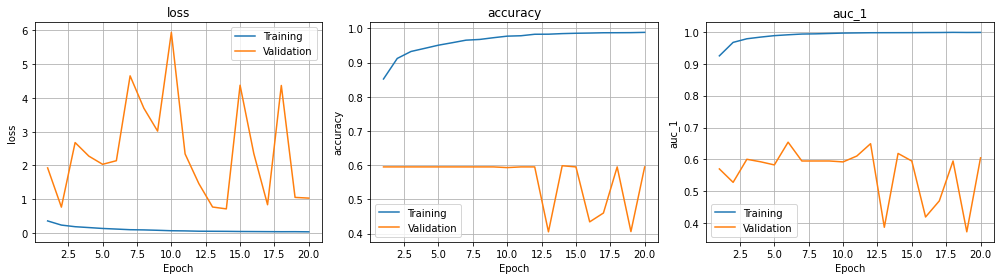

In [49]:
history1 = merge_history([h1])
vis_training(history1)

### Train ResNet

In [50]:
base_model = res.ResNet50V2(input_shape=(96,96,3), include_top=False, weights='imagenet')

cnn_res = Sequential([
    base_model,
    
    Flatten(),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')
])
opt = tf.keras.optimizers.Adam(0.001)
cnn_res.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])
cnn_res.summary()

94683136/94668760 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 3, 3, 2048)        23564800  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                1179712   
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_______________________________________________________

In [51]:
%%time 

h2 = cnn_res.fit(
    x = train_loader, 
    steps_per_epoch = TR_STEPS, 
    epochs = 20,
    validation_data = valid_loader, 
    validation_steps = VA_STEPS, 
    verbose = 1
)

Epoch 1/20
688/688 [==============================] - 149s 209ms/step - loss: 0.3892 - accuracy: 0.8374 - auc_2: 0.9122 - val_loss: 0.4117 - val_accuracy: 0.8361 - val_auc_2: 0.9022
Epoch 2/20
688/688 [==============================] - 139s 203ms/step - loss: 0.2656 - accuracy: 0.8959 - auc_2: 0.9578 - val_loss: 1.3293 - val_accuracy: 0.7012 - val_auc_2: 0.6903
Epoch 3/20
688/688 [==============================] - 142s 206ms/step - loss: 0.2348 - accuracy: 0.9110 - auc_2: 0.9667 - val_loss: 0.5869 - val_accuracy: 0.8686 - val_auc_2: 0.9154
Epoch 4/20
688/688 [==============================] - 141s 204ms/step - loss: 0.2044 - accuracy: 0.9240 - auc_2: 0.9744 - val_loss: 1.4227 - val_accuracy: 0.7394 - val_auc_2: 0.7751
Epoch 5/20
688/688 [==============================] - 142s 207ms/step - loss: 0.1859 - accuracy: 0.9304 - auc_2: 0.9788 - val_loss: 0.2589 - val_accuracy: 0.8999 - val_auc_2: 0.9645
Epoch 6/20
688/688 [==============================] - 144s 209ms/step - loss: 0.1688 - acc

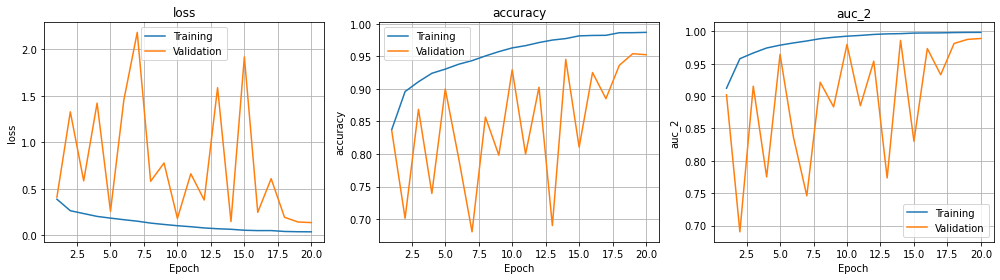

In [52]:
history2 = merge_history([h2])
vis_training(history2)

### Train Inception

In [53]:
base_model = inc.InceptionV3(input_shape=(96,96,3), include_top=False, weights='imagenet')

cnn_inc = Sequential([
    base_model,
    
    Flatten(),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')
])
opt = tf.keras.optimizers.Adam(0.001)
cnn_inc.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])
cnn_inc.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                131136    
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_______________________________________________________

In [54]:
%%time 

h3 = cnn_inc.fit(
    x = train_loader, 
    steps_per_epoch = TR_STEPS, 
    epochs = 20,
    validation_data = valid_loader, 
    validation_steps = VA_STEPS, 
    verbose = 1
)

Epoch 1/20
688/688 [==============================] - 149s 206ms/step - loss: 0.5253 - accuracy: 0.7645 - auc_3: 0.8336 - val_loss: 2.2188 - val_accuracy: 0.7813 - val_auc_3: 0.8240
Epoch 2/20
688/688 [==============================] - 141s 205ms/step - loss: 0.4198 - accuracy: 0.8238 - auc_3: 0.8957 - val_loss: 1.7927 - val_accuracy: 0.7526 - val_auc_3: 0.7908
Epoch 3/20
688/688 [==============================] - 141s 205ms/step - loss: 0.4130 - accuracy: 0.8294 - auc_3: 0.8969 - val_loss: 0.6354 - val_accuracy: 0.7161 - val_auc_3: 0.8342
Epoch 4/20
688/688 [==============================] - 140s 204ms/step - loss: 0.3608 - accuracy: 0.8541 - auc_3: 0.9220 - val_loss: 0.4074 - val_accuracy: 0.8175 - val_auc_3: 0.9152
Epoch 5/20
688/688 [==============================] - 140s 203ms/step - loss: 0.3905 - accuracy: 0.8387 - auc_3: 0.9096 - val_loss: 0.5651 - val_accuracy: 0.7096 - val_auc_3: 0.7913
Epoch 6/20
688/688 [==============================] - 140s 203ms/step - loss: 0.4029 - acc

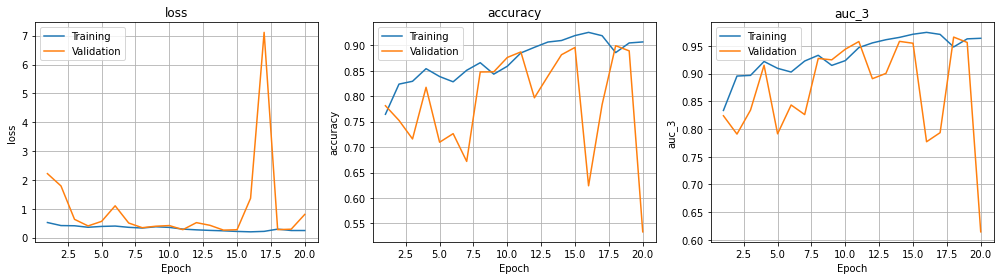

In [55]:
history3 = merge_history([h3])
vis_training(history3)

### Since Inception showed the best accuracy, I will try to improve the accuracy of Inception by decreasing the learing rate.

In [15]:
base_model = inc.InceptionV3(input_shape=(96,96,3), include_top=False, weights='imagenet')

cnn_inc = Sequential([
    base_model,
    
    Flatten(),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')
])
opt = tf.keras.optimizers.Adam(0.0001)
cnn_inc.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])
cnn_inc.summary()

2022-07-17 14:41:24.039047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 14:41:24.155640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 14:41:24.156489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 14:41:24.157726: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________

In [16]:
%%time 

h4 = cnn_inc.fit(
    x = train_loader, 
    steps_per_epoch = TR_STEPS, 
    epochs = 20,
    validation_data = valid_loader, 
    validation_steps = VA_STEPS, 
    verbose = 1
)

2022-07-17 14:42:21.602302: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-07-17 14:42:29.493283: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


688/688 [==============================] - 344s 478ms/step - loss: 0.9001 - accuracy: 0.5605 - auc: 0.5690 - val_loss: 0.6003 - val_accuracy: 0.6938 - val_auc: 0.7681
Epoch 2/20
688/688 [==============================] - 139s 202ms/step - loss: 0.7189 - accuracy: 0.6537 - auc: 0.6918 - val_loss: 0.5197 - val_accuracy: 0.7688 - val_auc: 0.8492
Epoch 3/20
688/688 [==============================] - 138s 200ms/step - loss: 0.5978 - accuracy: 0.7275 - auc: 0.7826 - val_loss: 0.4802 - val_accuracy: 0.7929 - val_auc: 0.8771
Epoch 4/20
688/688 [==============================] - 139s 202ms/step - loss: 0.5285 - accuracy: 0.7683 - auc: 0.8306 - val_loss: 0.4459 - val_accuracy: 0.8114 - val_auc: 0.8952
Epoch 5/20
688/688 [==============================] - 159s 231ms/step - loss: 0.4833 - accuracy: 0.7943 - auc: 0.8602 - val_loss: 0.4128 - val_accuracy: 0.8264 - val_auc: 0.9105
Epoch 6/20
688/688 [==============================] - 139s 202ms/step - loss: 0.4405 - accuracy: 0.8141 - auc: 0.8853 - v

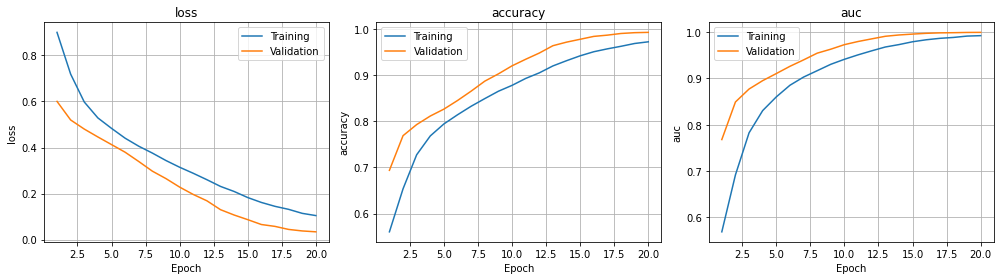

In [17]:
history4 = merge_history([h4])
vis_training(history4)

## Conclussion

Reducing the learning rate of Inception using 0.0001 and 0.00001 showed me that 90% accuracy for 0.0001 and 87% of accuracy for 0.00001. So, for submission, I chose the result with the learing rate of 0.0001.

In [19]:
import pickle
cnn_inc.save('HCDv03_inc.h5')
pickle.dump(history4, open(f'HCDv03_inc.pk2', 'wb'))

In [66]:
import pickle
cnn_efn.save('HCDv01_efn.h5')
pickle.dump(history1, open(f'HCDv01_efn.pk2', 'wb'))
cnn_res.save('HCDv01_res.h5')
pickle.dump(history2, open(f'HCDv01_res.pk2', 'wb'))
cnn_inc.save('HCDv01_inc.h5')
pickle.dump(history3, open(f'HCDv01_inc.pk2', 'wb'))

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [20]:
test = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
print('Test Set Size:', test.shape)
test['filename'] = test.id + '.tif'
test.head()

Test Set Size: (57458, 2)


,id,label,filename
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif
1,95596b92e5066c5c52466c90b69ff089b39f2737,0,95596b92e5066c5c52466c90b69ff089b39f2737.tif
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif
3,2c35657e312966e9294eac6841726ff3a748febf,0,2c35657e312966e9294eac6841726ff3a748febf.tif
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif


In [23]:
test_path = "../input/histopathologic-cancer-detection/test"
print('Test Images:', len(os.listdir(test_path)))

Test Images: 57458


In [24]:
BATCH_SIZE = 64

test_datagen = ImageDataGenerator(rescale=1/255)

test_loader = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = test_path,
    x_col = 'filename',
    batch_size = BATCH_SIZE,
    shuffle = False,
    class_mode = None,
    target_size = (96,96)
)

Found 57458 validated image filenames.


## Prepare Submission

In [71]:
test_probs = cnn_efn.predict(test_loader)
print(test_probs.shape)
print(len(test_loader))
print(test_probs[:10,].round(2))
test_pred = np.argmax(test_probs, axis=1)
print(test_pred[:10])
submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
submission.label = test_probs[:,1]
submission.to_csv('submission_efn.csv', header=True, index=False)

(57458, 2)
898
[[0.85 0.15]
 [0.93 0.07]
 [0.83 0.17]
 [0.87 0.13]
 [0.9  0.1 ]
 [0.97 0.03]
 [0.9  0.1 ]
 [0.88 0.12]
 [0.86 0.14]
 [0.9  0.1 ]]
[0 0 0 0 0 0 0 0 0 0]


In [72]:
test_probs = cnn_res.predict(test_loader)
print(test_probs.shape)
print(len(test_loader))
print(test_probs[:10,].round(2))
test_pred = np.argmax(test_probs, axis=1)
print(test_pred[:10])
submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
submission.label = test_probs[:,1]
submission.to_csv('submission_res.csv', header=True, index=False)

(57458, 2)
898
[[0.45 0.55]
 [0.74 0.26]
 [1.   0.  ]
 [0.99 0.01]
 [0.11 0.89]
 [0.   1.  ]
 [0.42 0.58]
 [0.04 0.96]
 [1.   0.  ]
 [0.6  0.4 ]]
[1 0 0 0 1 1 1 1 0 0]


In [25]:
test_probs = cnn_inc.predict(test_loader)
print(test_probs.shape)
print(len(test_loader))
print(test_probs[:10,].round(2))
test_pred = np.argmax(test_probs, axis=1)
print(test_pred[:10])
submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
submission.label = test_probs[:,1]
submission.to_csv('submission2_inc.csv', header=True, index=False)

(57458, 2)
898
[[1.   0.  ]
 [0.94 0.06]
 [0.92 0.08]
 [0.99 0.01]
 [0.98 0.02]
 [0.3  0.7 ]
 [0.88 0.12]
 [0.96 0.04]
 [0.99 0.01]
 [0.99 0.01]]
[0 0 0 0 0 1 0 0 0 0]
